<!-- ## Loading of Stringer orientations data

includes some visualizations -->

# Load, preprocess data and run NMF and cross-validation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from umap import UMAP
from scipy.ndimage import gaussian_filter1d

from scipy.ndimage import uniform_filter1d

# @title Install depedencies
!pip install umap-learn --quiet

c:\Users\zaggila\Anaconda3\envs\pixelNMF\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load data (here: oreinattion, or look at sponts notebook and loader)

In [2]:
#@title Data retrieval
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [3]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [4]:
# @title Data loading

dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])


# Define save_directory

In [ ]:
save_dir = r'C:\Users\zaggila\Desktop\NMA' #define 

# zscore data 

In [8]:
acts = zscore(dat['sresp'], axis=1)

# NMF

## Shift data to positive (zscored, is that ok ?)

In [ ]:
# # Run NMF for an optimal number defined by cross-validation

# # Non negative data as input , shifting ditribution to positive, check if that is fine; shift data to positive values by adding min value 

data_pos = np.abs(np.min(acts)) + acts
data_pos = np.array(data_pos)

# Cross - validation

In [16]:
from sklearn.decomposition import NMF
import numpy as np
import itertools

def cv_nmf_sklearn(data, r_max, step, replicates, p_holdout=0.3, max_iter=10000, tol=1e-4 ): #tol=1e-4
    """
    Perform cross-validated NMF using scikit-learn's NMF implementation.

    Parameters:
    - data: Input dataset (2D array).
    - r_max: Maximum rank to test
    - step: Step size for ranks (e.g., test rank 10, 20, ..., r_max).
    - replicates: Number of replicates for each rank.
    - p_holdout: Proportion of data to hold out for testing (default 0.3).
    - max_iter: Maximum number of iterations for NMF (default 200).
    - tol: Tolerance for stopping criterion (default 1e-4).

    Returns:
    - train_err: List of training errors for each rank.
    - test_err: List of testing errors for each rank.
    """

    # Create ranks array
    ranks = np.arange(1, r_max, step)

    # Initialize error lists
    train_err = []
    test_err = []

    # Create a masking matrix for the missing data (1 = observed, 0 = held out)
    M = np.random.rand(*data.shape) > p_holdout
    masked_data = np.where(M, data, 0)

    # Loop through each rank and each replicate
    for rank, _ in itertools.product(ranks, range(replicates)):
        print(f"Fitting NMF with rank = {rank}")

        # Initialize and fit NMF model with scikit-learn
        model = NMF(n_components=rank, init='random', max_iter=max_iter, random_state=0)
        W = model.fit_transform(masked_data)
        H = model.components_

        # Reconstruct the data from the factorized matrices
        reconstructed_data = np.dot(W, H)

        # Calculate residual (difference between actual and reconstructed data)
        resid = reconstructed_data - data

        # Calculate training and testing errors
        train_err_r = np.mean(resid[M] ** 2)  # Only consider observed data in training
        test_err_r = np.mean(resid[~M] ** 2)  # Only consider held-out data in testing

        # Append the errors
        train_err.append((rank, train_err_r))
        test_err.append((rank, test_err_r))

        print(f"Finished running for rank: {rank} | Training error: {train_err_r:.2f}, Test error: {test_err_r:.2f}")

    return train_err, test_err


def plot_cv_opt(train_err, test_err):
    train_err_np = np.array([te[1] for te in train_err])  # Extract train error values
    test_err_np = np.array([te[1] for te in test_err])    # Extract test error values
    ranks = np.array([te[0] for te in test_err])          # Extract rank values

    # Get the rank with the lowest test error
    n_nmf_min = np.argmin(test_err_np)

    # Find the elbow point using kneelocator 
    knee_locator = KneeLocator(ranks, test_err_np, curve="convex", direction="decreasing")
    n_nmf_elbow = knee_locator.knee

    fig, ax = plt.subplots(1, 1, figsize=(4, 3.5), dpi=200)
    ax.plot(ranks, train_err_np, 'o-', label='Train Data')
    ax.plot(ranks, test_err_np, 'o-', label='Test Data')
    ax.set_ylabel('MSE')
    ax.set_xlabel('Rank')
    ax.axvline(ranks[n_nmf_min], color='grey', dashes=[1,1.5], label='min')

    if n_nmf_elbow is not None:
        ax.axvline(n_nmf_elbow, color='black', label='elbow') # or ranks[n_nmf_elbow]

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='upper right', fontsize=10)
    fig.tight_layout()
    plt.savefig(save_dir + 'cv_nmf.png')
    plt.show()

    return n_nmf_min, n_nmf_elbow

# Parameter set for cv

In [13]:
# set parameters to test for 
r_max = 150 # maximum rank (cluster) to test for 
step= 5 # step per rank (eg if 5, test for n=1,6,11,...,100)
replicates=1 #replicate or not 

In [14]:
train_err, test_err = cv_nmf_sklearn(data_pos, r_max, step, replicates)

Fitting NMF with rank = 1
Finished running for rank: 1 | Training error: 1.05, Test error: 1.05
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.97, Test error: 0.97
Fitting NMF with rank = 11
Finished running for rank: 11 | Training error: 0.92, Test error: 0.93
Fitting NMF with rank = 16
Finished running for rank: 16 | Training error: 0.89, Test error: 0.90
Fitting NMF with rank = 21
Finished running for rank: 21 | Training error: 0.87, Test error: 0.88
Fitting NMF with rank = 26
Finished running for rank: 26 | Training error: 0.85, Test error: 0.87
Fitting NMF with rank = 31
Finished running for rank: 31 | Training error: 0.83, Test error: 0.86
Fitting NMF with rank = 36
Finished running for rank: 36 | Training error: 0.82, Test error: 0.85
Fitting NMF with rank = 41
Finished running for rank: 41 | Training error: 0.81, Test error: 0.85
Fitting NMF with rank = 46
Finished running for rank: 46 | Training error: 0.80, Test error: 0.84
Fitting NMF with rank = 

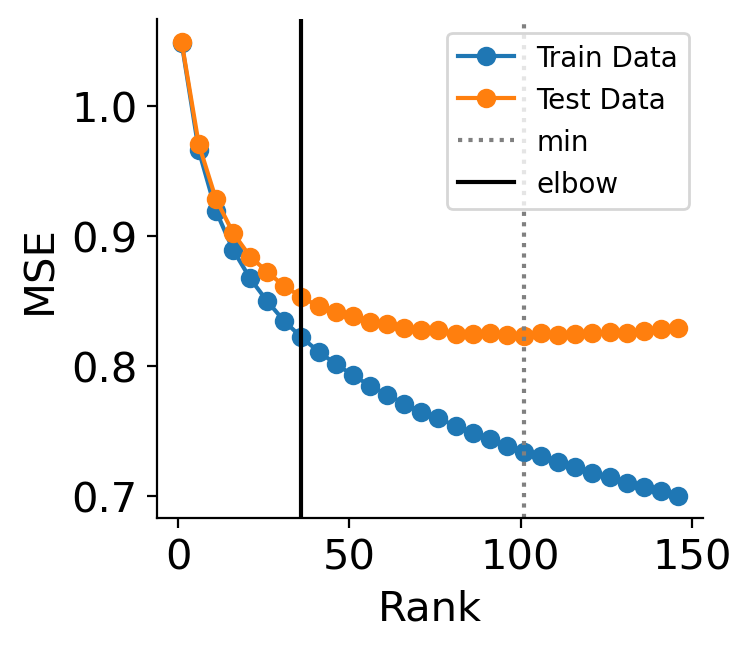

In [17]:
from kneed import DataGenerator, KneeLocator

n_nmf_opt, n_nmf_elbow = plot_cv_opt(train_err, test_err)

# NMF (n_components = optimal_n from cv)

In [ ]:
n_components = n_nmf_elbow 

# Run NMF with the optimal number of components
model = NMF(n_components=n_components, max_iter=1000, init='random', random_state=0, verbose=True, l1_ratio=0.5)
W = model.fit_transform(data_pos)
H = model.components_

NameError: name 'NMF' is not defined

## Visualise nmfs - H (time) and W (neurons) matrcices 

In [ ]:
W.shape #should be (n_neurons, n_components)

(23589, 30)

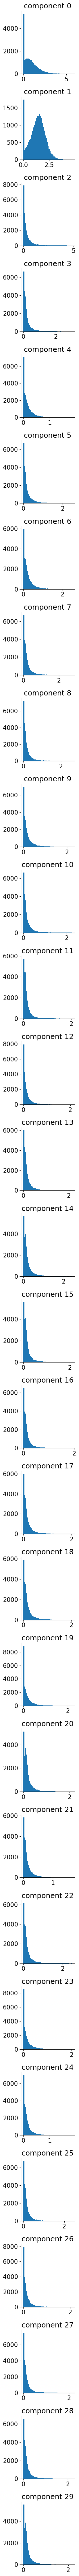

In [ ]:
fig, axs = plt.subplots(n_components, 1, figsize=(3,3*n_components))
for i in range(n_components):
    axs[i].hist(W.T[i,:], bins=50)
    axs[i].set_title(f'component {i}')

plt.savefig(save_dir + 'W_NMF_hists.png')  # Save the figure to the drive

plt.show()

# Plot NMF - vars 

In [29]:
def minmax_scale(data):
    data = data - np.min(data)/np.max(data) - np.min(data)
    return data

C:\Users\zaggila\AppData\Local\Temp\ipykernel_43516\4178400517.py:15: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


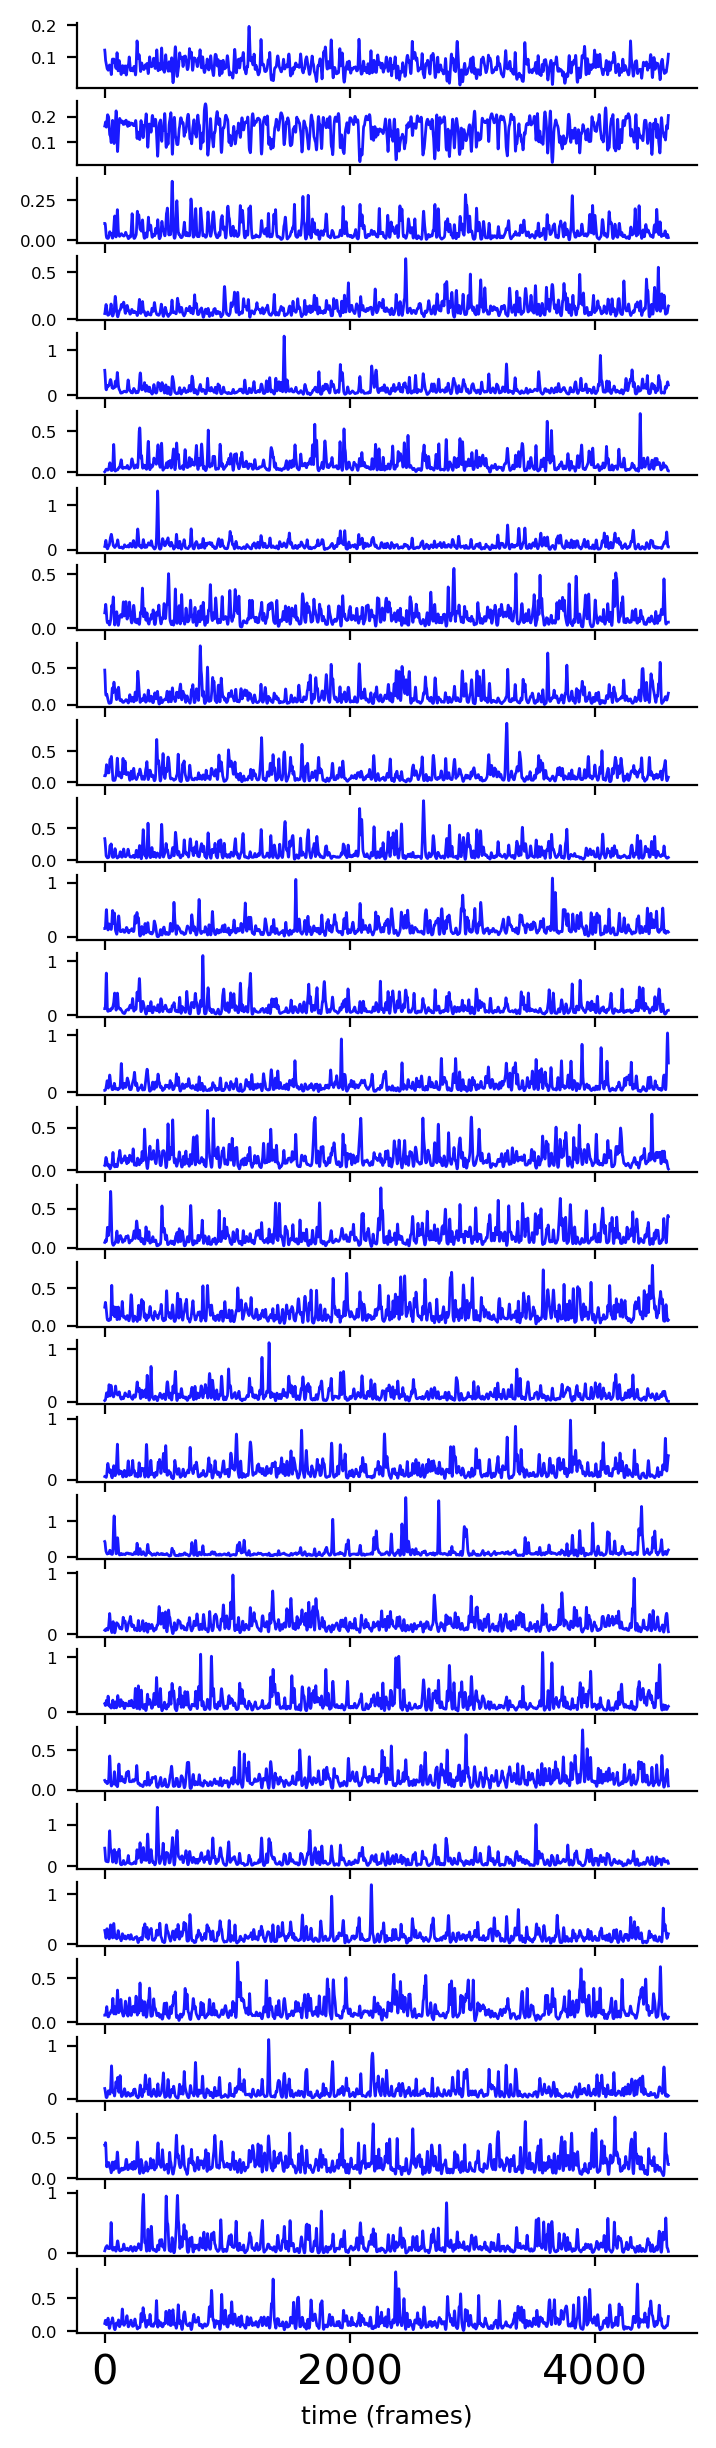

In [ ]:
fig, axs = plt.subplots(len(H),1, figsize=(4,0.5*len(H)), dpi=200)

zoom = len(H.T)

for i in range(len(H)):
    axs[i].plot(gaussian_filter1d(minmax_scale(H[i][:zoom]), sigma=4), alpha=0.9, color='b', linewidth=1)

    # axs[i].plot(speed, c='orange', alpha=0.3)
    # axs[i].plot(acceleration, c='r')

    # axs[i].set_title(f'nmf no. {i}')
    axs[i].tick_params(axis='y', labelsize=6)
    axs[-1].set_xlabel('time (frames)', fontsize=9)

plt.tight_layout()
plt.show()

# Save outputs 

In [ ]:
outputs_dict = {
    "NMF_W_neuron_matrix": W, #shape neurons, n_comps 
    "NMF_H_time_matrix" : H, #shape n_comps, time 
   # 'vonmises_pdf': vonmises_pdf #for all n_neurons
}

save_dir = r'C:\Users\zaggila\Desktop\NMA' #your save_dir 
file_path = os.path.join(save_dir, "outputs_dict.npy")
np.save(file_path, outputs_dict)
np.save(save_dir + "outputs_dict.npy", outputs_dict)